In [8]:
import numpy as np
from scipy.sparse import csr_matrix, find
import warnings

# Convert RuntimeWarning to an error
warnings.filterwarnings("error", category=RuntimeWarning)

def funk_svd_sparse(R, num_factors=10, alpha=0.01, beta=0.01, num_iterations=100, epsilon = 0.001):
    """
    Perform Funk SVD on the given sparse user-item matrix R.

    Parameters:
    - R (csr_matrix): Sparse user-item matrix.
    - num_factors (int): Number of latent factors.
    - alpha (float): Learning rate.
    - beta (float): Regularization parameter.
    - num_iterations (int): Number of iterations for SGD.
    - epsilon (float): Minimal change in rmse to keep training.

    Returns:
    - U (ndarray): User-factor matrix.
    - V (ndarray): Item-factor matrix.
    """
    num_users, num_items = R.shape
    U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
    V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

    training_process = []

    for iteration in range(num_iterations):
        # Get the non-zero indices (observed ratings)
        rows, cols, values = find(R)

        for i, j, r in zip(rows, cols, values):
            prediction = np.dot(U[i, :], V[j, :])
            error = r - prediction

            # Update user and item latent feature matrices
            U[i, :] += alpha * (error * V[j, :] - beta * U[i, :])
            V[j, :] += alpha * (error * U[i, :] - beta * V[j, :])

        rmse = np.sqrt(np.mean([(r - np.dot(U[i, :], V[j, :]))**2 for i, j, r in zip(rows, cols, values)]))
        training_process.append((iteration, rmse))
        print(f"Iteration: {iteration+1}, RMSE: {rmse}")
        if len(training_process) >= 2  and rmse + epsilon >= training_process[-2][1]:
            print("Early stopping!")
            break

    return U, V, training_process

# Example usage:
R_sparse = csr_matrix([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

U, V, training_process = funk_svd_sparse(R_sparse, num_factors=5, alpha=0.01, beta=0.01, num_iterations=50,epsilon=0.001)
print("User latent feature matrix:")
print(U)
print("Item latent feature matrix:")
print(V)


Iteration: 1, RMSE: 3.248004443652745
Iteration: 2, RMSE: 3.2372831291822717
Iteration: 3, RMSE: 3.226420556763744
Iteration: 4, RMSE: 3.2151925832818606
Iteration: 5, RMSE: 3.203376196601929
Iteration: 6, RMSE: 3.1907447901709265
Iteration: 7, RMSE: 3.177064102342706
Iteration: 8, RMSE: 3.162088822267366
Iteration: 9, RMSE: 3.145559936986435
Iteration: 10, RMSE: 3.1272029683061944
Iteration: 11, RMSE: 3.106727323025008
Iteration: 12, RMSE: 3.083827052796026
Iteration: 13, RMSE: 3.0581833825831146
Iteration: 14, RMSE: 3.0294694060493352
Iteration: 15, RMSE: 2.9973573426097007
Iteration: 16, RMSE: 2.961528678273414
Iteration: 17, RMSE: 2.9216873406784867
Iteration: 18, RMSE: 2.87757575932994
Iteration: 19, RMSE: 2.8289932183790367
Iteration: 20, RMSE: 2.7758153320037957
Iteration: 21, RMSE: 2.71801281779949
Iteration: 22, RMSE: 2.655667128630033
Iteration: 23, RMSE: 2.58898010803695
Iteration: 24, RMSE: 2.5182748771801697
Iteration: 25, RMSE: 2.443985840153618
Iteration: 26, RMSE: 2.366

In [9]:
import pandas as pd

import sys
# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

In [10]:
users,ratings,movies = load_data('../../data/ml-1m')

In [11]:
ratings = ratings.sort_values(by='timestamp',ascending=True)
train_ratings, test_ratings = ratings.iloc[:int(len(ratings)*0.8)],ratings.iloc[int(len(ratings)*0.8):]


In [12]:
user_item_matrix_train = train_ratings.pivot(index='user_id', columns='movie_id', values='rating')
user_item_matrix_train.fillna(0,inplace=True)
user_item_matrix_train.shape

(5400, 3662)

In [13]:
# def compute_rmse_test(U, V, test_ratings):
#     """
#     Compute the RMSE on the test set.

#     Parameters:
#     - U (ndarray): User latent feature matrix.
#     - V (ndarray): Item latent feature matrix.
#     - test_ratings (DataFrame): Test ratings DataFrame with columns ['user_id', 'movie_id', 'rating'].

#     Returns:
#     - rmse (float): Root mean squared error on the test set.
#     """
#     errors = []
#     for row in test_ratings.itertuples():
#         user, item, actual_rating = row.user_id, row.movie_id, row.rating
#         if user in user_index and item in item_index:
#             user_idx = user_index[user]
#             item_idx = item_index[item]
#             predicted_rating = np.dot(U[user_idx, :], V[item_idx, :])
#             errors.append((actual_rating - predicted_rating) ** 2)

#     rmse = np.sqrt(np.mean(errors))
#     return rmse


# # Creating a mapping of user and item indices
# user_index = {user: idx for idx, user in enumerate(user_item_matrix_train.index)}
# item_index = {item: idx for idx, item in enumerate(user_item_matrix_train.columns)}

# # Compute RMSE on the test set
# test_rmse = compute_rmse_test(U, V, test_ratings)
# print(f"Test RMSE: {test_rmse}")


In [14]:
def predict_ratings(U, V):
    """
    Predict ratings for all user-item pairs.

    Parameters:
    - U (ndarray): User latent feature matrix.
    - V (ndarray): Item latent feature matrix.

    Returns:
    - predicted_ratings (ndarray): Matrix of predicted ratings.
    """
    return np.dot(U, V.T)

def generate_recommendations(U, V, train_ratings, k=5):
    """
    Generate top-k recommendations for each user, excluding movies seen in training.

    Parameters:
    - U (ndarray): User latent feature matrix.
    - V (ndarray): Item latent feature matrix.
    - train_ratings (DataFrame): Training ratings DataFrame with columns ['user_id', 'movie_id', 'rating'].
    - k (int): Number of recommendations to generate for each user.

    Returns:
    - recommendations (dict): Dictionary of recommendations where keys are user IDs and values are lists of recommended movie IDs.
    """
    # Predict ratings
    predicted_ratings = predict_ratings(U, V)
    
    # Create a DataFrame from the predicted ratings
    user_index = {user: idx for idx, user in enumerate(train_ratings['user_id'].unique())}
    item_index = {item: idx for idx, item in enumerate(train_ratings['movie_id'].unique())}
    user_ids = train_ratings['user_id'].unique()
    movie_ids = train_ratings['movie_id'].unique()
    predicted_df = pd.DataFrame(predicted_ratings, index=user_ids, columns=movie_ids)
    
    # Exclude movies seen in training
    train_user_item = train_ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    for user in train_user_item.index:
        seen_movies = train_user_item.loc[user][train_user_item.loc[user] > 0].index
        predicted_df.loc[user, seen_movies] = -np.inf
    
    # Generate top-k recommendations
    recommendations = {}
    for user in user_ids:
        recommended_items = predicted_df.loc[user].nlargest(k).index.tolist()
        recommendations[user] = recommended_items
    
    return recommendations

## Perform grid-search

In [15]:
import random

factor_values = [5,10,15,20,25,30]
alpha_values = [0.005,0.01,0.02]
num_iteration_values = [10,15,20,25,30,40]
beta_values = alpha_values.copy()
num_samples = 10
random_samples = [
    (random.choice(factor_values), random.choice(num_iteration_values), random.choice(beta_values), random.choice(alpha_values))
    for _ in range(num_samples)
]
results = []
for factor, iterations, beta_value, alpha_value in random_samples:
    print(factor, alpha_value, beta_value, iterations)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("error", RuntimeWarning)
            U, V, training_process = funk_svd_sparse(user_item_matrix_train, num_factors=factor, alpha=alpha_value, beta=beta_value, num_iterations=iterations, epsilon=0.001)
            recommendations = generate_recommendations(U, V, train_ratings, k=25)
            results.append({(factor, iterations, beta_value, alpha_value): recommendations})
    except RuntimeWarning as warn:
        print(f"{warn} Stopping execution")

25 0.02 0.01 20
overflow encountered in multiply Stopping execution
10 0.01 0.005 25
Iteration: 1, RMSE: 3.228450011330035
Iteration: 2, RMSE: 1.2169038753607886
Iteration: 3, RMSE: 1.0157018561241624
Iteration: 4, RMSE: 0.9510696588311399
Iteration: 5, RMSE: 0.9139879764050499
Iteration: 6, RMSE: 0.8882253006172586
Iteration: 7, RMSE: 0.8688217426762275
Iteration: 8, RMSE: 0.8539276066019745
Iteration: 9, RMSE: 0.8424053483265139
Iteration: 10, RMSE: 0.8333889331617749
Iteration: 11, RMSE: 0.8262275524875228
Iteration: 12, RMSE: 0.8204488315895307
Iteration: 13, RMSE: 0.8157139773106663
Iteration: 14, RMSE: 0.8117790593503997
Iteration: 15, RMSE: 0.8084662552386893
Iteration: 16, RMSE: 0.8056438226710866
Iteration: 17, RMSE: 0.8032125296901709
Iteration: 18, RMSE: 0.8010965060014045
Iteration: 19, RMSE: 0.7992370121547637
Iteration: 20, RMSE: 0.7975881124317441
Iteration: 21, RMSE: 0.7961135965025491
Iteration: 22, RMSE: 0.7947847349495137
Iteration: 23, RMSE: 0.7935786064963508
Itera

KeyboardInterrupt: 

In [18]:
metrics = {}
total_movies = len(ratings['movie_id'].unique())
k_values = [25, 20, 15, 10, 5]

for res in results:
    for k_tuple in res:
        recommendation_ = res[k_tuple]
        metrics[k_tuple] = {}
        for k in k_values:
            cropped_recommendation = {user: films[:k] for user, films in recommendation_.items()}
            metrics[k_tuple][k] = evaluate_recommender_system(cropped_recommendation, test_ratings, total_movies, k)

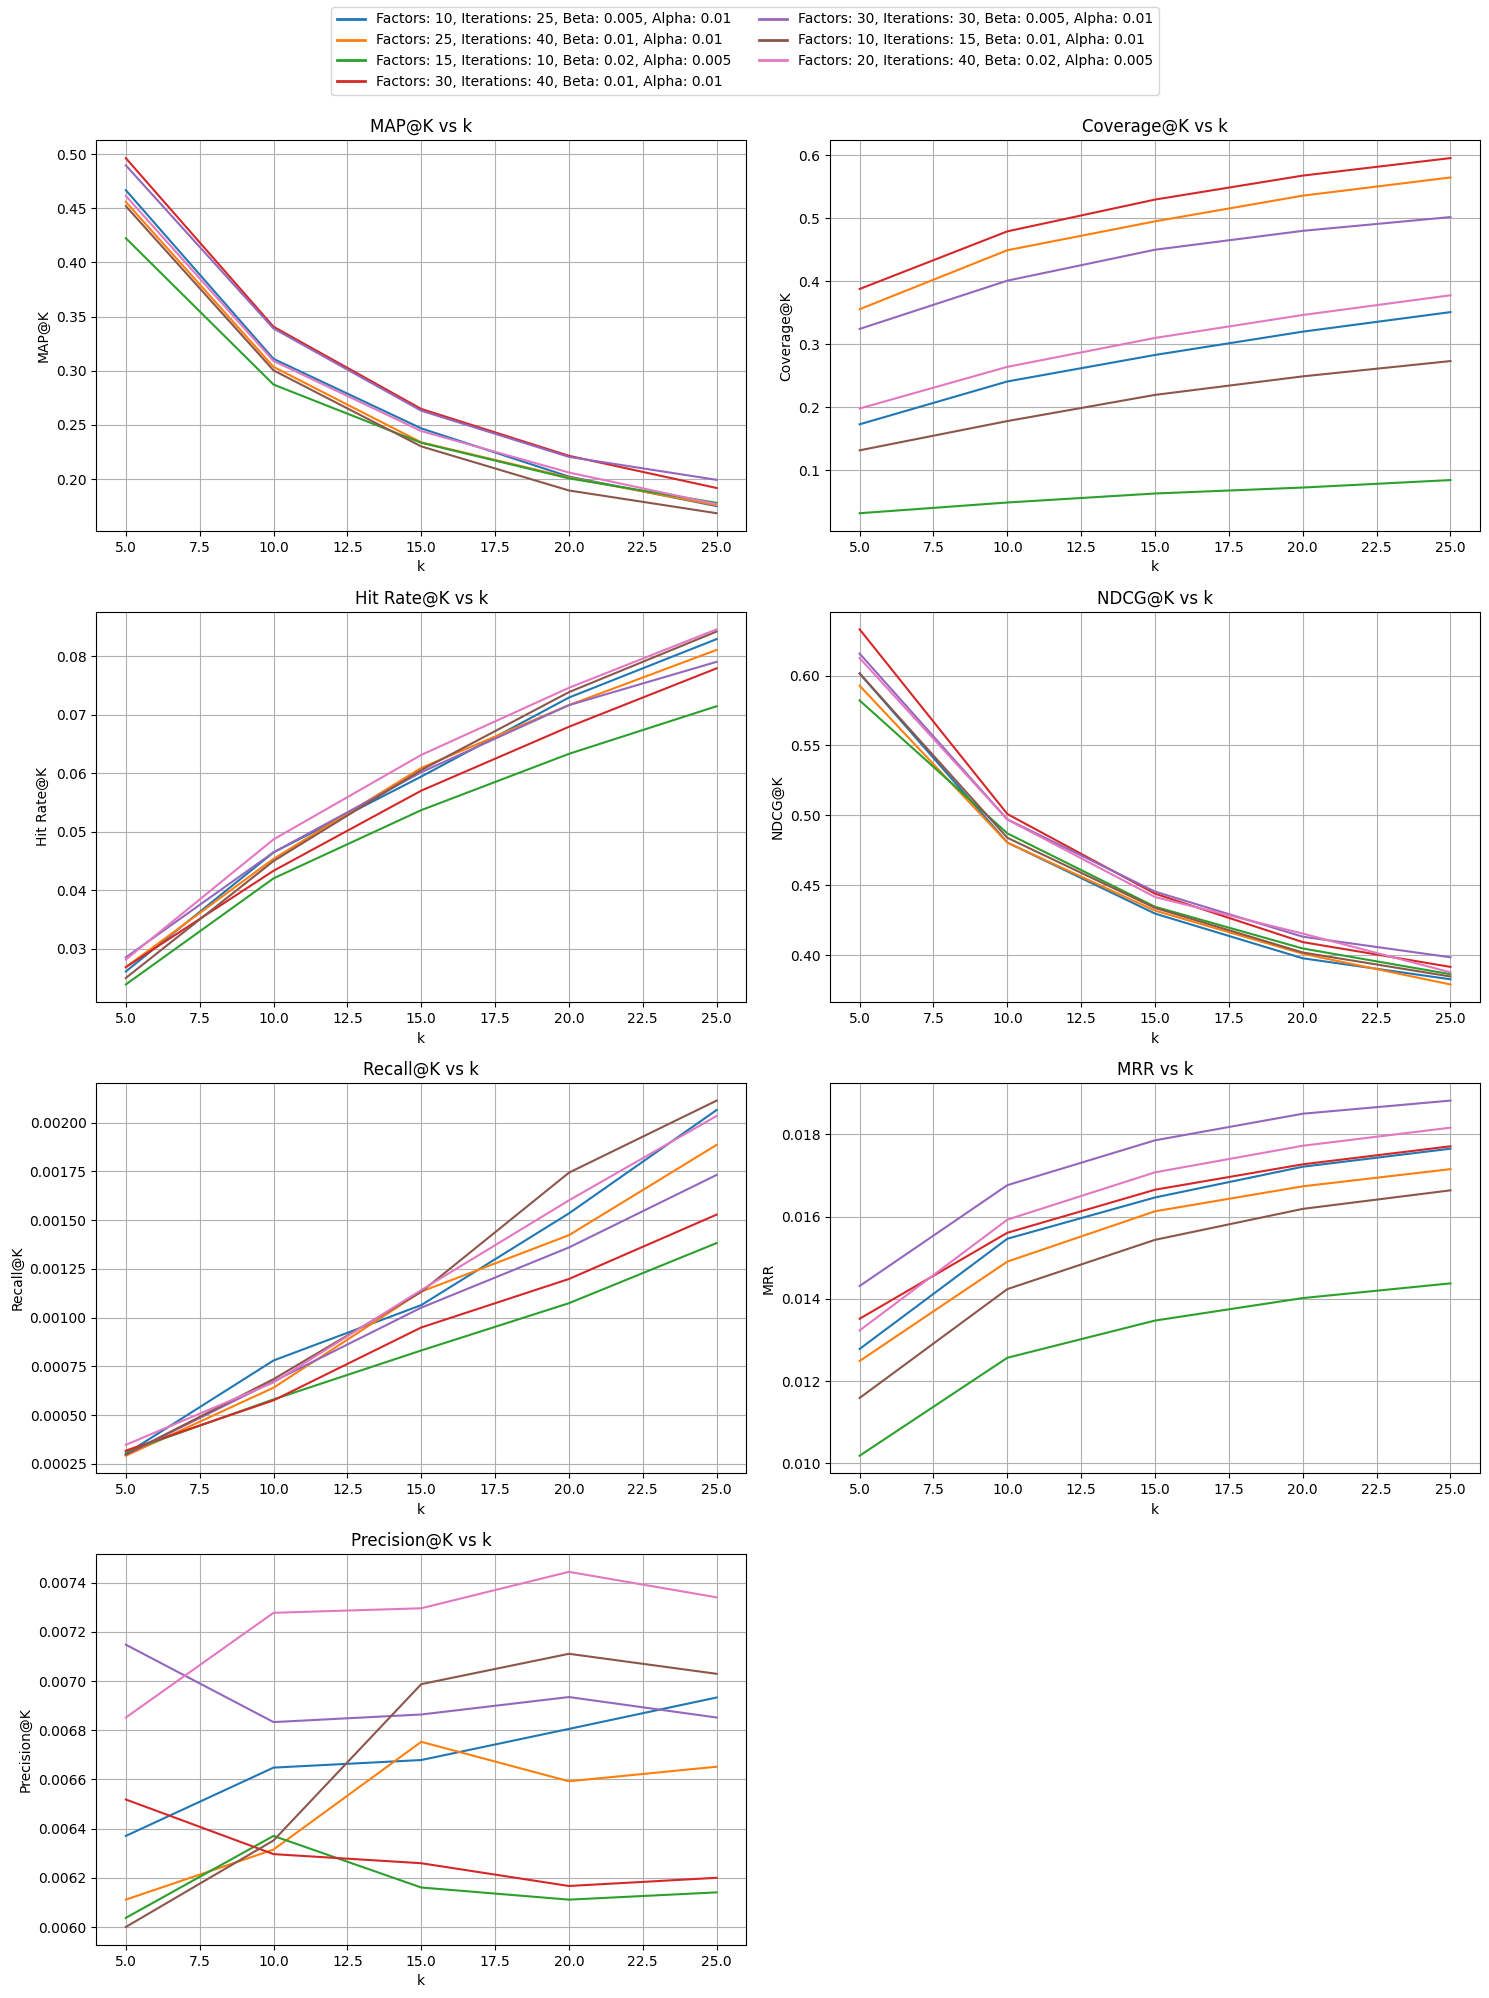

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
all_metric_names = set()
for k_tuple in metrics:
    for k in metrics[k_tuple]:
        all_metric_names.update(metrics[k_tuple][k].keys())

all_metric_names = list(all_metric_names)
num_metrics = len(all_metric_names)
num_cols = 2  # Number of columns in the grid
num_rows = (num_metrics + num_cols - 1) // num_cols  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Flatten to easily iterate over them

# Generate unique colors for each k_tuple
colors = list(mcolors.TABLEAU_COLORS.values())
color_map = {k_tuple: colors[i % len(colors)] for i, k_tuple in enumerate(metrics)}

for idx, metric_name in enumerate(all_metric_names):
    ax = axes[idx]
    for k_tuple in metrics:
        ks = sorted(metrics[k_tuple].keys())
        metric_values = [metrics[k_tuple][k][metric_name] for k in ks]
        label = f"Factors: {k_tuple[0]}, Iterations: {k_tuple[1]}, Beta: {k_tuple[2]}, Alpha: {k_tuple[3]}"
        ax.plot(ks, metric_values, label=label, color=color_map[k_tuple])

    ax.set_xlabel('k')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} vs k')
    ax.grid(True)

# Add a single legend
handles, labels = [], []
for k_tuple, color in color_map.items():
    label = f"Factors: {k_tuple[0]}, Iterations: {k_tuple[1]}, Beta: {k_tuple[2]}, Alpha: {k_tuple[3]}"
    handles.append(plt.Line2D([0, 1], [0, 1], color=color, lw=2))
    labels.append(label)
fig.legend(handles, labels, loc='upper center', ncol=2)

# Hide any unused subplots
for idx in range(num_metrics, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the legend
plt.show()

In [38]:
# Generate recommendations
recommendations = generate_recommendations(U, V, train_ratings, k=5)

# Evaluate the recommendations
total_movies = len(ratings['movie_id'].unique())
evaluation_metrics = evaluate_recommender_system(recommendations, test_ratings, total_movies, k=5)
print(evaluation_metrics)

{'Precision@K': 0.006185185185185185, 'Recall@K': 0.00031613840376955966, 'NDCG@K': 0.5973940992997296, 'MAP@K': 0.460260172143975, 'MRR': 0.01220679012345679, 'Hit Rate@K': 0.026296296296296297, 'Coverage@K': 0.3402590393955747}


In [39]:
evaluation_metrics

{'Precision@K': 0.006185185185185185,
 'Recall@K': 0.00031613840376955966,
 'NDCG@K': 0.5973940992997296,
 'MAP@K': 0.460260172143975,
 'MRR': 0.01220679012345679,
 'Hit Rate@K': 0.026296296296296297,
 'Coverage@K': 0.3402590393955747}

In [28]:
# 20
evaluation_metrics

{'Precision@K': 0.005888888888888889,
 'Recall@K': 0.0003409722823506432,
 'NDCG@K': 0.5870866206732365,
 'MAP@K': 0.45507518796992485,
 'MRR': 0.011314814814814814,
 'Hit Rate@K': 0.02462962962962963,
 'Coverage@K': 0.16675661090124122}

In [21]:
# 10 
evaluation_metrics

{'Precision@K': 0.004629629629629629,
 'Recall@K': 0.00019307912594388474,
 'NDCG@K': 0.5826582956595987,
 'MAP@K': 0.4518348623853212,
 'MRR': 0.009188271604938271,
 'Hit Rate@K': 0.020185185185185184,
 'Coverage@K': 0.22558014031300594}